# Run sentence embeddings on Bencini and Goldberg (2000) stimuli

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import torch
from collections import defaultdict
import random
import math
import pickle
import sklearn.decomposition

import src.sent_encoder

%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [2]:
df = pd.read_csv("../data/bencini-goldberg.csv")

In [3]:
enc = src.sent_encoder.SentEncoder()

In [4]:
sent_vecs = enc.sentence_vecs(df.sentence.tolist())

## PCA plot (dim=2)

In [5]:
layer = 11
pca_model = sklearn.decomposition.PCA(n_components=2)
pca_vecs = pca_model.fit_transform(np.array(sent_vecs)[:, layer])

In [6]:
pca_vecs.shape

(16, 2)

In [7]:
df['PC1'] = pca_vecs[:, 0]
df['PC2'] = pca_vecs[:, 1]

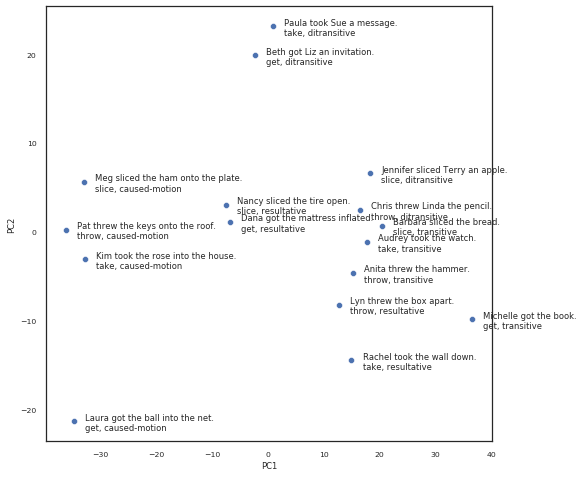

In [8]:
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(font_scale=0.7)
sns.set_style('white')
g = sns.scatterplot(x=df.PC1, y=df.PC2)
for _, row in df.iterrows():
  label_text = f"{row.sentence}\n{row.verb}, {row.construction}"
  g.text(row['PC1'] + 2, row['PC2'] - 1, label_text)
plt.show()

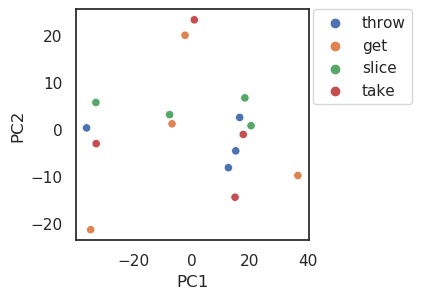

In [9]:
matplotlib.rc_file_defaults()
sns.set(rc={'figure.figsize':(3, 3)})
sns.set_style('white')
sns.scatterplot(x=df.PC1, y=df.PC2, hue=df.verb)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

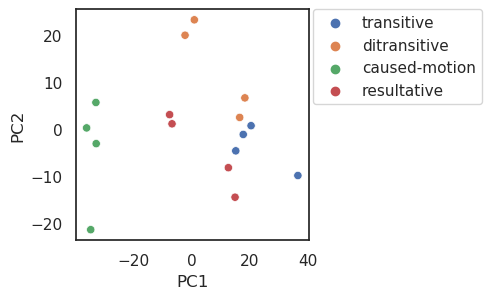

In [10]:
matplotlib.rc_file_defaults()
sns.set(rc={'figure.figsize':(3, 3)})
sns.set_style('white')
sns.scatterplot(x=df.PC1, y=df.PC2, hue=df.construction)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

## Compute mean pairwise distances

In [11]:
def verb_cxn_mean_distance(df, sent_vecs, layer):
  verb_distances = []
  cxn_distances = []
  for i in range(16):
    for j in range(i+1, 16):
      dist = np.linalg.norm(sent_vecs[i][layer] - sent_vecs[j][layer])
      if df.iloc[i].verb == df.iloc[j].verb:
        verb_distances.append(dist)
      if df.iloc[i].construction == df.iloc[j].construction:
        cxn_distances.append(dist)
  return np.mean(verb_distances), np.mean(cxn_distances)

In [12]:
layer_results = []
for layer in range(13):
  verb_distance, cxn_distance = verb_cxn_mean_distance(df, sent_vecs, layer)
  layer_results.append({
    "layer": layer,
    "verb_distance": verb_distance,
    "cxn_distance": cxn_distance,
  })
layer_results = pd.DataFrame(layer_results)

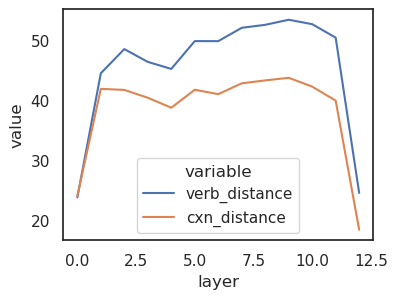

In [13]:
sns.set(rc={'figure.figsize':(4, 3)})
sns.set_style("white")
sns.lineplot(data=layer_results.melt(id_vars=["layer"]), x="layer", y="value", hue="variable")
plt.show()

## Repeat with lots of generated stimuli sets

In [17]:
templated_df = pd.read_csv("../data/bencini-goldberg-templated.csv")

In [15]:
results = []
for group in range(len(templated_df) // 16):
  df = templated_df[templated_df.group == group]
  sent_vecs = enc.sentence_vecs(df.sentence.tolist())
  
  for layer in range(13):
    verb_distance, cxn_distance = verb_cxn_mean_distance(df, sent_vecs, layer)
    results.append({
      "group": group,
      "layer": layer,
      "verb_distance": verb_distance,
      "cxn_distance": cxn_distance,
    })

results = pd.DataFrame(results)

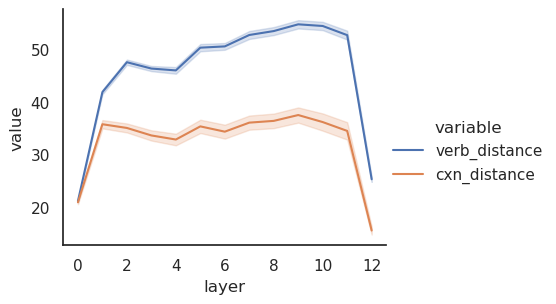

In [16]:
sns.set_style("white")
sns.relplot(data=results.melt(id_vars=["group", "layer"]), x="layer", y="value", hue="variable",
            kind="line", ci="sd", aspect=4/3, height=3)
plt.show()